In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression

In C:\Users\ZukiPC\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ZukiPC\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ZukiPC\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\ZukiPC\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ZukiPC\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
data = pd.read_csv('train_with_norelevant.csv').drop('Unnamed: 0', axis=1)

C:\Users\ZukiPC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,...,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,Year,Month,Hour,Day_of_week,Week,aux
0,47b07238-a9b6-4ef7-a209-7a1fd8c88149,Vehicle search,2019-12-03 00:00:00+00:00,NaN,54.548325,-1.271298,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Caution (simple or conditional),False,NaN,cleveland,2019,12,0,Tuesday,49,"('cleveland', 'White', 'Male')"
1,be1ce6a4-89b7-49a2-bc2a-00868a115c42,Vehicle search,2019-12-04 12:12:00+00:00,False,51.382699,0.543110,Male,10-17,Asian/Asian British - Indian,Asian,...,Arrest,True,False,kent,2019,12,12,Wednesday,49,"('kent', 'Asian', 'Male')"
2,2f44c551-7fe3-475f-8ed6-ae3e24928505,Vehicle search,2018-09-25 00:41:00+00:00,False,53.608913,-2.138118,Male,18-24,Asian/Asian British - Pakistani,Asian,...,A no further action disposal,False,False,greater-manchester,2018,9,0,Tuesday,39,"('greater-manchester', 'Asian', 'Male')"
3,564e42e2-16e5-4fdc-a140-1e4406d8941e,Vehicle search,2018-09-07 19:00:00+00:00,True,51.190980,0.269950,Male,18-24,Other ethnic group - Not stated,Other,...,Summons / charged by post,False,NaN,kent,2018,9,19,Friday,36,"('kent', 'Other', 'Male')"
4,4fdcc05d-44c0-477a-a9c7-55c15efb319c,Vehicle search,2018-09-07 19:21:00+00:00,True,51.190980,0.269950,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Summons / charged by post,False,NaN,kent,2018,9,19,Friday,36,"('kent', 'White', 'Male')"


In [4]:
data.shape

(309044, 22)

In [5]:
relevance = data.groupby([data.aux]).size().reset_index()
relevance.columns = ('aux', 'nb')

In [6]:
no_relevant = relevance[relevance.nb < 30].aux.unique()

In [7]:
len(no_relevant)

109

In [8]:
train = data[data.aux.isin(no_relevant)==False]

In [9]:
train.shape

(308048, 22)

In [10]:
train['target']= (
    np.where(
    train['Outcome linked to object of search']==True,
    1,
    0)
)

C:\Users\ZukiPC\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
columns_to_drop = ['observation_id', 'Part of a policing operation',
       'Latitude', 'Longitude', 
       'Self-defined ethnicity', 'Legislation',
       'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'target', 'aux']

In [12]:
X = train.drop(columns=columns_to_drop)
y = train['target']

In [51]:
categorical_features = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity',
       'Object of search', 'station']

numerical_features = ['Year', 'Month', 'Hour', 'Day_of_week',
       'Week']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=7, max_depth = 30, min_samples_split= 200, max_leaf_nodes=5),
)

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Gender',
                                                   'Age range',
                                                   'Officer-defined ethnicity',
                                                   'Object of search',
                                                   'station'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_leaf_nodes=5,
                                        min_samples_split=200, n_estimators=7,
                                        n_jobs=-1, random_state=42))])

In [35]:
preds = pipeline.predict(X_test)

In [18]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision

In [19]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred)    
    return recall

In [36]:
verify_success_rate_above(y_test, preds)

(True, 0.8421900161030595)

In [37]:
verify_amount_found(y_test, preds)

0.08455258265297874

In [23]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Officer-defined ethnicity', max_diff=0.10, min_samples=500):
    """
    Verifies that no subdeparment has discrimination in between protected races
    
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions

In [38]:
is_satisfied, problematic_departments, good_deparments, global_precisions  = verify_no_discrimination(
    X_test, y_test, preds)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
else:
    print("Requirement satisfied! 🚀")

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement satisfied! 🚀
avg diff: nan


C:\Users\ZukiPC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ZukiPC\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
is_satisfied, problematic_departments, good_deparments, global_precisions  = verify_no_discrimination(
    X_test, y_test, preds, sensitive_column='Gender')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
else:
    print("Requirement satisfied! 🚀")

print("avg diff:", np.mean([p[1] for p in problematic_departments]))

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement satisfied! 🚀
avg diff: nan


C:\Users\ZukiPC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ZukiPC\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
proba = pipeline.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, proba[:, 1])

In [41]:
precision = precision[:-1]
recall = recall[:-1]

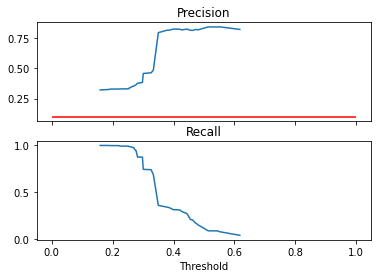

In [42]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.1,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.xlabel('Threshold')
plt.show()

In [43]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.1][0]

In [44]:
thresholds[min_index]

0.15900632952143962

In [45]:
best_preds = [1 if pred > thresholds[min_index] else 0 for pred in proba[:, 1]]

In [46]:
verify_success_rate_above(y_test, best_preds)

(False, 0.32481224725592145)

In [47]:
verify_amount_found(y_test, best_preds)

0.9998787486864441

# Try Logistic Regression

In [125]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(),
)

In [126]:
pipeline.fit(X_train, y_train)

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Gender',
                                                   'Age range',
                                                   'Officer-defined ethnicity',
                                                   'Object of search',
                                                   'station'])])),
                ('logisticregression', LogisticRegression(C=10))])

In [127]:
preds2 = pipeline.predict(X_test)

In [128]:
verify_success_rate_above(y_test, preds2)

(True, 0.7591785061190041)

In [129]:
verify_amount_found(y_test, preds2)

0.43626222617411686

In [130]:
is_satisfied, problematic_departments, good_deparments, global_precisions  = verify_no_discrimination(
    X_test, y_test, preds2)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
else:
    print("Requirement satisfied! 🚀")

print("avg diff:", np.mean([p[1] for p in problematic_departments]))

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement failed 😢
Num problematic departments: 5
Num good departments: 36
avg diff: 0.367565410929704


In [118]:
is_satisfied, problematic_departments, good_deparments, global_precisions  = verify_no_discrimination(
    X_test, y_test, preds2, sensitive_column='Gender')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
else:
    print("Requirement satisfied! 🚀")

print("avg diff:", np.mean([p[1] for p in problematic_departments]))

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement failed 😢
Num problematic departments: 2
Num good departments: 39
avg diff: 0.13578627053203327


In [109]:
is_satisfied, problematic_departments, good_deparments, global_precisions  = verify_no_discrimination(
    X_test, y_test, preds2, sensitive_column='Age range')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
else:
    print("Requirement satisfied! 🚀")

print("avg diff:", np.mean([p[1] for p in problematic_departments]))

C:\Users\ZukiPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement failed 😢
Num problematic departments: 7
Num good departments: 34
avg diff: 0.3924828918246974
